**Thoracic Surgery** множеството претставува реално медицинско множество од UCI Machine Learning Repository кое содржи податоци за пациенти кои биле подложни на торакална хирургија (операција на бели дробови).

Целта на ова множество е да се предвиди дали пациентот ќе почине во рок од една година по извршената операција.

Ова претставува проблем на надгледувано учење, поточно проблем на бинарна класификација, каде што постојат две класи:

**True** – пациентот починал во рок од една година по операцијата

**False** – пациентот преживеал.

In [92]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import SelectKBest, f_classif
from imblearn.over_sampling import SMOTE
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from sklearn.metrics import classification_report, confusion_matrix

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

In [49]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [50]:
df = pd.read_csv("/content/drive/My Drive/ProjectData/ThoraricSurgery.csv")

In [51]:
df.head()

,id,DGN,PRE4,PRE5,PRE6,PRE7,PRE8,PRE9,PRE10,PRE11,PRE14,PRE17,PRE19,PRE25,PRE30,PRE32,AGE,Class
0,1,DGN2,2.88,2.16,PRZ1,F,F,F,T,T,OC14,F,F,F,T,F,60,F
1,2,DGN3,3.40,1.88,PRZ0,F,F,F,F,F,OC12,F,F,F,T,F,51,F
2,3,DGN3,2.76,2.08,PRZ1,F,F,F,T,F,OC11,F,F,F,T,F,59,F
3,4,DGN3,3.68,3.04,PRZ0,F,F,F,F,F,OC11,F,F,F,F,F,54,F
4,5,DGN3,2.44,0.96,PRZ2,F,T,F,T,T,OC11,F,F,F,T,F,73,T


In [52]:
df = df.drop(columns=['id'])

In [53]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 470 entries, 0 to 469
Data columns (total 17 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   DGN     470 non-null    object 
 1   PRE4    470 non-null    float64
 2   PRE5    470 non-null    float64
 3   PRE6    470 non-null    object 
 4   PRE7    470 non-null    object 
 5   PRE8    470 non-null    object 
 6   PRE9    470 non-null    object 
 7   PRE10   470 non-null    object 
 8   PRE11   470 non-null    object 
 9   PRE14   470 non-null    object 
 10  PRE17   470 non-null    object 
 11  PRE19   470 non-null    object 
 12  PRE25   470 non-null    object 
 13  PRE30   470 non-null    object 
 14  PRE32   470 non-null    object 
 15  AGE     470 non-null    int64  
 16  Class   470 non-null    object 
dtypes: float64(2), int64(1), object(14)
memory usage: 62.6+ KB


Во множеството имаме 470 примероци, 16 влезни променливи **(DGN, PRE4, PRE5, PRE6, PRE7, PRE8, PRE9, PRE10, PRE11, PRE14, PRE17, PRE19, PRE25, PRE30, PRE32, AGE)** и една излезна променлива **Class**.

Од влезните променливи 2 се од тип float **(PRE4 и PRE5)**, 1 од тип int **(AGE)** додека останатите се од тип object.

Според излезот од df.info() може да заклучиме дека немаме null вредности во ниту една колона, па нема потреба од отфрлање на редови или пополнување со дополнителни податоци.

Објаснување на влезните карактеристики:

**DGN**: 	Дијагноза - специфична комбинација на ICD-10 кодови за примарни и секундарни, како и повеќекратни тумори, доколку ги има.('DGN2' 'DGN3' 'DGN4' 'DGN8' 'DGN5' 'DGN6' 'DGN1')

**PRE4**	Форсиран витален капацитет - FVC

**PRE5**	Волумен што е издишан на крајот од првата секунда од присилното издишување - FEV1

**PRE6**	Статус на перформанси - Зубродова скала ('PRZ2', 'PRZ1', 'PRZ0')


**PRE7**	Болка пред операција (T,F)


**PRE8**	Хемоптиза пред операција - кашлање со крв(T,F)

**PRE9**  Диспнеја пред операција - отежнато дишење (T,F)

**PRE10**	 Кашлица пред операција (T,F)

**PRE11** 	Слабост пред операција (T,F)

**PRE14**  Т во клиничкиот TNM - големина на оригиналниот тумор, од OC11 (најмал) до OC14 (најголем) (OC11, OC12, OC13, OC14)

**PRE17** Тип 2 ДМ - дијабетес мелитус (T,F)

**PRE19**	 МИ до 6 месеци - миокарден инфаркт или срцев удар(T,F)

**PRE25**  PAD - периферни артериски заболувања (T,F)

**PRE30** 	Пушач (T,F)

**PRE32** 	Астма (T,F)

**AGE** 	 Години на пациентот која ја направил операцијата

In [54]:
df.columns = ['Diagnosis','FVC','FEV1','Performance','Pain','Hemoptysis','Dyspnea','Cough','Weakness','Tumor size','Diabetes','MI','PAD','Smoker','Asthma', 'Age','Class']

Бидејќи 10 влезни променливи заедно со излезната променлива кои се од тип object се со вредности T/F може да ги претвориме во int вредности така што Т ќе го замениме со 1 и F ќе го замениме со 0.

In [55]:
column_names = [col for col in df.columns if df[col].isin(['T', 'F']).all()]
df[column_names] = df[column_names].replace({'T':1, 'F':0}).astype(int)

/tmp/ipython-input-2866302203.py:2: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df[column_names] = df[column_names].replace({'T':1, 'F':0}).astype(int)


In [56]:
df.head()

,Diagnosis,FVC,FEV1,Performance,Pain,Hemoptysis,Dyspnea,Cough,Weakness,Tumor size,Diabetes,MI,PAD,Smoker,Asthma,Age,Class
0,DGN2,2.88,2.16,PRZ1,0,0,0,1,1,OC14,0,0,0,1,0,60,0
1,DGN3,3.40,1.88,PRZ0,0,0,0,0,0,OC12,0,0,0,1,0,51,0
2,DGN3,2.76,2.08,PRZ1,0,0,0,1,0,OC11,0,0,0,1,0,59,0
3,DGN3,3.68,3.04,PRZ0,0,0,0,0,0,OC11,0,0,0,0,0,54,0
4,DGN3,2.44,0.96,PRZ2,0,1,0,1,1,OC11,0,0,0,1,0,73,1


In [57]:
df.describe()

,FVC,FEV1,Pain,Hemoptysis,Dyspnea,Cough,Weakness,Diabetes,MI,PAD,Smoker,Asthma,Age,Class
count,470.000000,470.000000,470.000000,470.000000,470.000000,470.000000,470.000000,470.000000,470.000000,470.000000,470.000000,470.000000,470.000000,470.000000
mean,3.281638,4.568702,0.065957,0.144681,0.065957,0.687234,0.165957,0.074468,0.004255,0.017021,0.821277,0.004255,62.534043,0.148936
std,0.871395,11.767857,0.248472,0.352154,0.248472,0.464114,0.372439,0.262811,0.065163,0.129488,0.383529,0.065163,8.706902,0.356405
min,1.440000,0.960000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,21.000000,0.000000
25%,2.600000,1.960000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,57.000000,0.000000
50%,3.160000,2.400000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,62.000000,0.000000
75%,3.807500,3.080000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,69.000000,0.000000
max,6.300000,86.300000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,87.000000,1.000000


In [58]:
X = df.drop(['Class'], axis=1)
y = df['Class']

feature_names = X.columns.tolist()
number_of_features = X.shape[1]
number_of_instances = X.shape[0]

print("Број и имиња на атрибути:", number_of_features, feature_names)
print("Број на податочни примероци:", number_of_instances)

Број и имиња на атрибути: 16 ['Diagnosis', 'FVC', 'FEV1', 'Performance', 'Pain', 'Hemoptysis', 'Dyspnea', 'Cough', 'Weakness', 'Tumor size', 'Diabetes', 'MI', 'PAD', 'Smoker', 'Asthma', 'Age']
Број на податочни примероци: 470


Class
0    400
1     70
Name: count, dtype: int64

Процентуална застапеност по класа:
Class
0    85.11
1    14.89
Name: count, dtype: float64


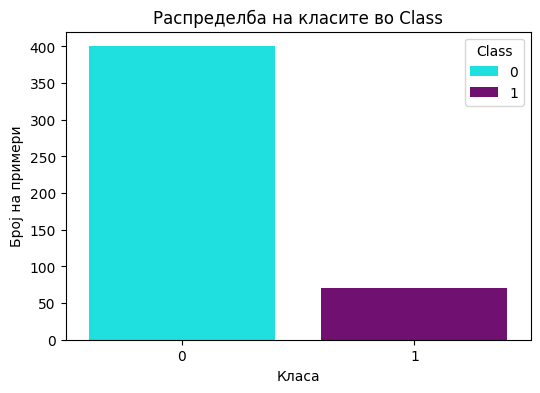

In [59]:
class_counts = y.value_counts()
print(class_counts)

print("\nПроцентуална застапеност по класа:")
print(round((class_counts / len(y)) * 100, 2))

plt.figure(figsize=(6,4))
sns.countplot(x=y, palette=['cyan', 'purple'], hue=y)
plt.title("Распределба на класите во Class")
plt.xlabel("Класа")
plt.ylabel("Број на примери")
plt.show()


При анализа на податоците може да се забележи дека 400 од 470 пациенти припаѓаат на класа 0, што значи дека преживеале 1 година по операцијата.

Меѓутоа, множеството е небалансирано, со околу 85% примери во негативната класа (0) и 15% во позитивната класа (1).

Ако податоците не се избалансираат, некои модели на машинско учење можат да даваат пристрасни или погрешни резултати, особено за позитивната класа.

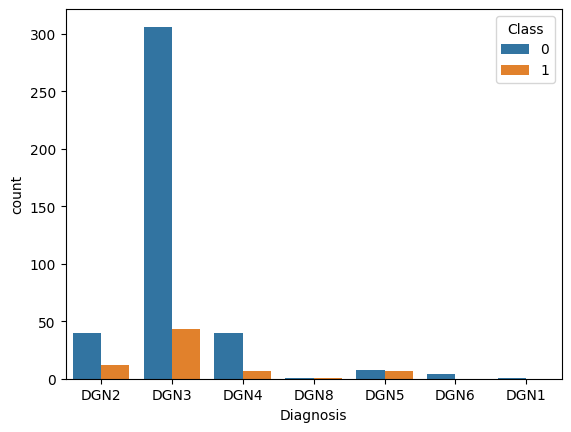

In [60]:
sns.countplot(x='Diagnosis', hue='Class', data=df)
plt.show()

Од графикот можеме да заклучиме дека дијагнозата DGN3 е најдоминантна дијагноза, особено кај класата 0 (преживеани пациенти) со околу 300 пациенти и околу 45 пациенти кај класата 1 (починати пациенти).

Втора најзастапена дијагноза е DGN2 со околу 40 пациенти кај класа 0 и околу 15 пациенти кај класа 1, проследена со DGN4 која има слична застапеност.

Дијагнозите DGN8 и DGN1 се со најмала застапеност, практично без регистрирани случаи.

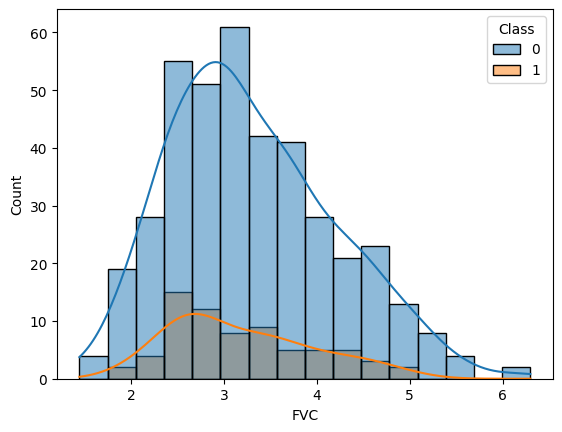

In [61]:
sns.histplot(data=df, x='FVC', hue='Class', kde=True)
plt.show()

Според графикот, пациентите од класата 0 имаат најголема фреквенција на FVC околу вредноста 3.0 - 3.5 со околу 60 пациенти.
Дистрибуцијата за класа 0 за оваа карактеристика изгледа приближно нормална.

Пациентите од класа 1 имаат најголема фреквенција на FVC околу вредноста 2.5 - 3.0 со околу 12 пациенти.

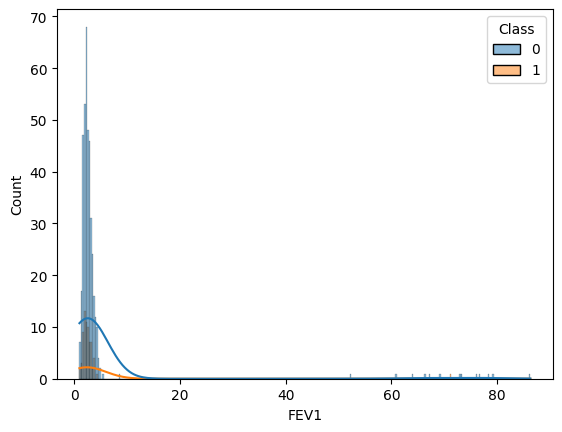

In [62]:
sns.histplot(data=df, x='FEV1', hue='Class', kde=True)
plt.show()

Според графикот и двете класи на пациенти покажуваат екстремна концентрација на FEV1 вредности блиску до 0, со пациентите од класата 0 имајќи врв од околу 50-70 пациенти и пациентите од класа 1 околу 10-12 пациенти на најниските вредности.

Ова укажува дека повеќето пациенти во ова множество имаат значително нарушена белодробна функција што е нормално за луѓе кои имаат белодробно заболување.

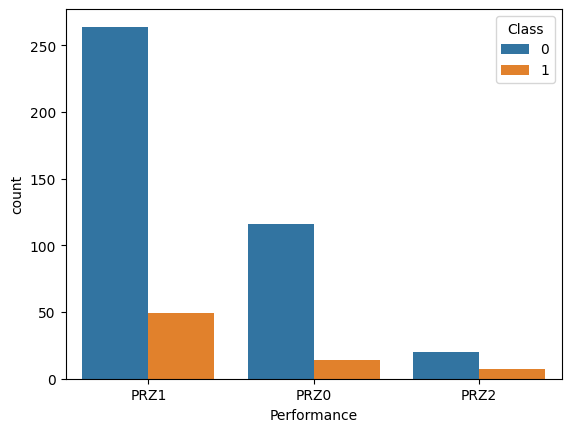

In [63]:
sns.countplot(x='Performance', hue='Class', data=df)
plt.show()

Од графикот може да видиме дека најраспространета вредност за карактеристиката Performance е PRZ1 што ја има кај 250 пациенти од класа 0 и околу 50 пациенти кај класа 1. Следна е PRZ0 што е застапена кај околу 110 пациенти од класа 0 и околу 20 пациенти кај класа 1. Најмалку застапена е PRZ2 со околу 20 пациенти од класа 0 и околу 10 пациенти кај класа 1.

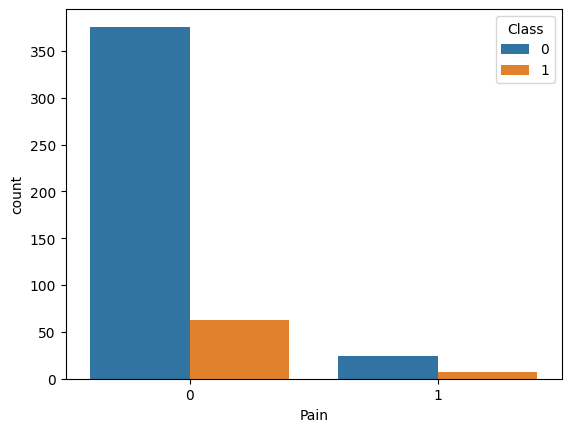

In [64]:
sns.countplot(x='Pain', hue='Class', data=df)
plt.show()

За карактеристиката Pain може да забележиме дека над 350 пациенти од класа 0 и околу 60 пациенти од класа 1 немале болка пред операцијата, додека пак околу 25 пациенти од класа 0 и околу 10 пациенти од класа 1 се соочиле со болка пред операцијата.

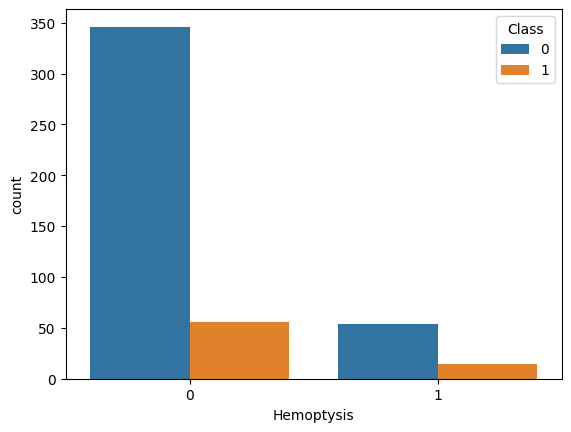

In [65]:
sns.countplot(x='Hemoptysis', hue='Class', data=df)
plt.show()

Слично како и кај променливата Pain, и кај променливата Hemoptysis најголем дел од пациентите се со вредност 0, односно пациентите немале кашлици проследени со крв пред операцијата.
Мал дел од пациентите, околу 50 од класа 0 и околу 15 од класа 1, се соочиле со оваа состојба.

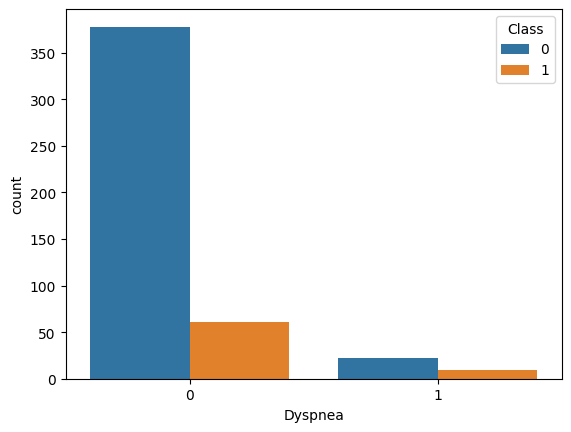

In [66]:
sns.countplot(x='Dyspnea', hue='Class', data=df)
plt.show()

Над 400 пациенти немале проблеми со отежнато дишење пред операцијата (околу 380 од класа 0 и околу 65 од класа 1), додека пак околу 25 пациенти од класа 0 и околу 10 пациенти од класа 1 се соочиле со оваа состојба.

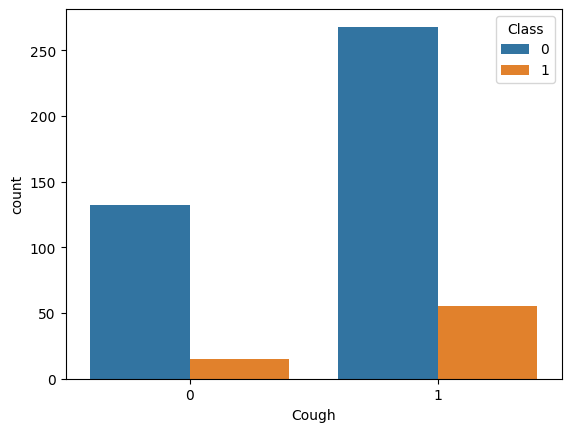

In [67]:
sns.countplot(x='Cough', hue='Class', data=df)
plt.show()

Според графикот погоре може да заклучиме дека нешто над 320 пациенти се соочиле со кашлица пред операцијата (околу 270 од класа 0 и околу 55 од класа 1), додека пак околу 150 пациенти не се соочиле со оваа состојба (околу 135 од класа 0 и околу 15 од класа 1).

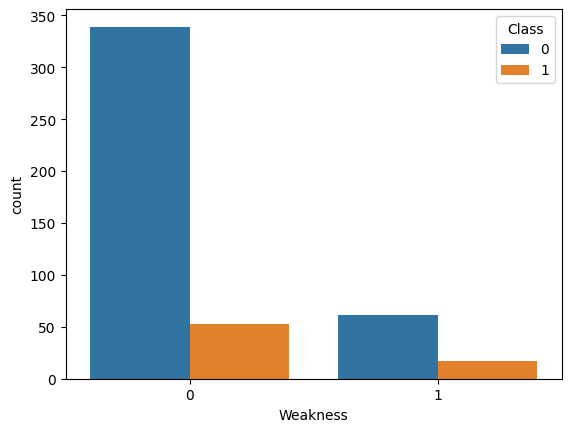

In [68]:
sns.countplot(x='Weakness', hue='Class', data=df)
plt.show()

Најголем дел од пациентите (околу 410, од кои 340 од класа 0 и 55 од класа 1) не почувствувале слабост, додека пак околу 80 пациенти (60 од класа 0 и 15 од класа 1) се соочиле со слабост пред извршената операција.

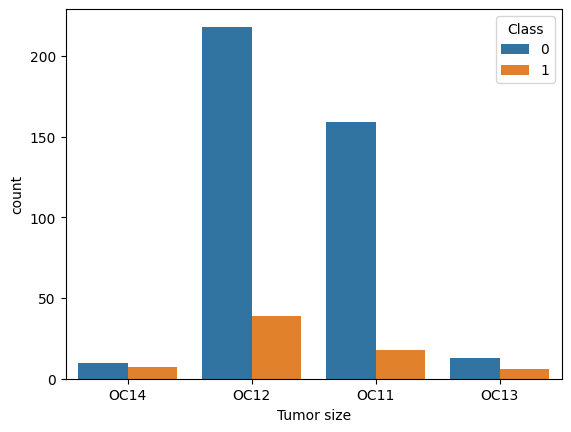

In [69]:
sns.countplot(x='Tumor size', hue='Class', data=df)
plt.show()

Според графикот може да забележиме дека најзастапена големина на тумор е OC12 (околу 220 од класа 0 и 40 од класа 1), што претставува втора најголема категорија на големина на тумор.

Втора по застапеност следува OC11 (околу 160 од класа 0 и 20 од класа 1), што претставува најмалата категорија на тумор.

Најмалку застапени се OC14 и OC13 со минимална фреквенција.

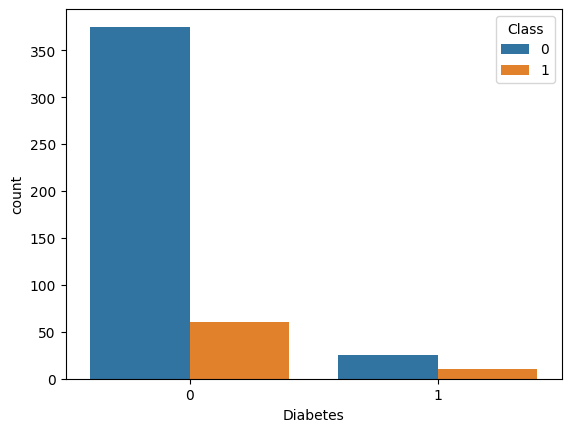

In [70]:
sns.countplot(x='Diabetes', hue='Class', data=df)
plt.show()

Може да забележиме дека голем дел од пациентите (околу 380 од негативната класа и 65 од позитивната класа) немале дијабетес пред извршената операција, додека пак околу 40 пациенти (околу 25 од класа 0 и 15 од класа 1) се соочиле со оваа болест.

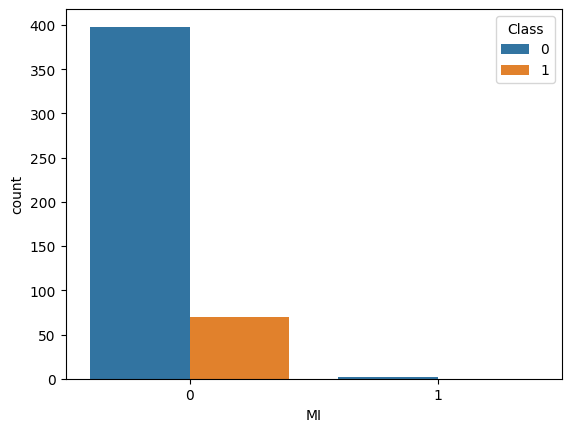

In [71]:
sns.countplot(x='MI', hue='Class', data=df)
plt.show()

Според резултатите погоре може да забележиме дека има само неколку пациенти (помалку од 5) кои доживеале срцев удар во последните 6 месеци пред операцијата на бели дробови, додека пак огромното мнозинство од пациентите (над 465, односно над 99%) не се соочиле со оваа состојба.

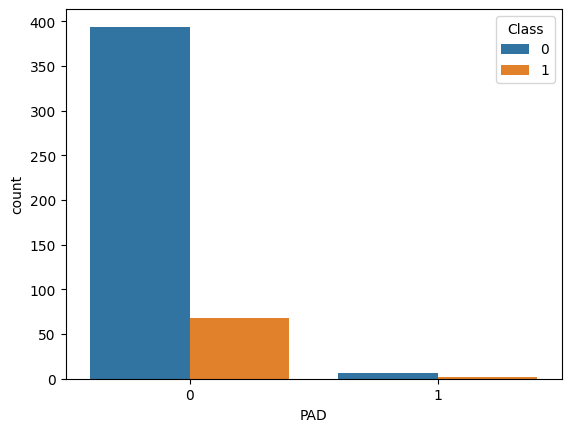

In [72]:
sns.countplot(x='PAD', hue='Class', data=df)
plt.show()

Најголем дел од пациентите (околу 460, односно 98%) немале периферни артериски заболувања пред направената операција, додека пак мал број (околу 10 пациенти, односно 2%) се соочиле со ова заболување.

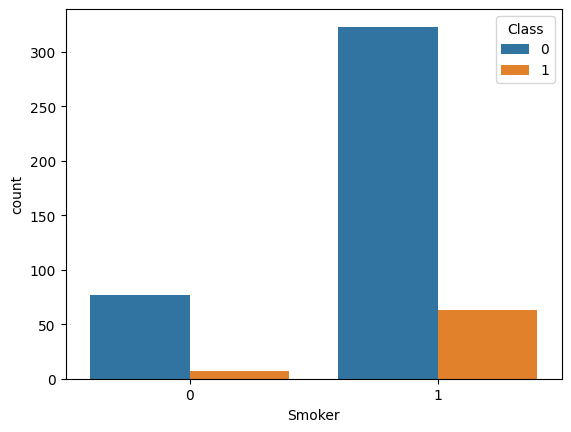

In [73]:
sns.countplot(x='Smoker', hue='Class', data=df)
plt.show()

Најголем дел од пациентите (над 320 пациенти од класа 0 и околу 60 пациенти од класа 1) биле пушачи, додека пак околу 90 пациенти (околу 80 од класа 0 и околу 10 од класа 1) не биле пушачи.

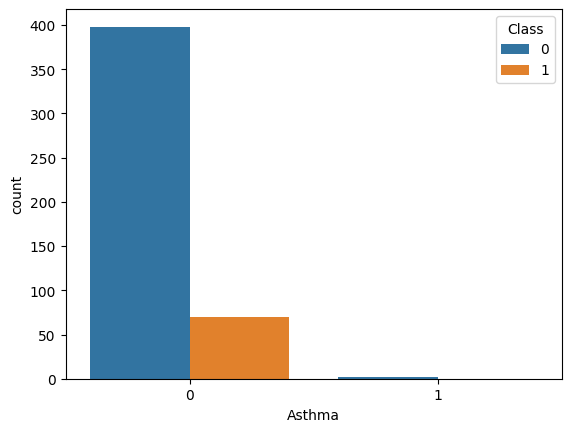

In [74]:
sns.countplot(x='Asthma', hue='Class', data=df)
plt.show()

Слично како и кај срцевиот удар (MI), и кај Asthma најголем дел од пациентите (над 465, односно над 98%) немале проблеми со астма пред извршената операција, додека само неколку пациенти (помалку од 5) се соочиле со ова заболување.

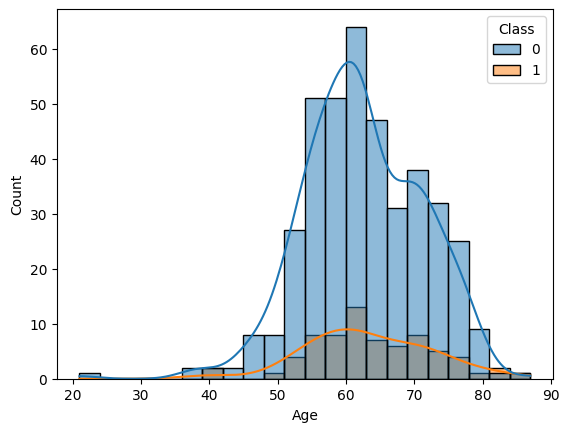

In [75]:
sns.histplot(data=df, x='Age', hue='Class', kde=True)
plt.show()

Според графикот за возраста на пациентите, и двете класи покажуваат приближно нормална дистрибуција со врв околу 60-65 години.
Пациентите од класа 0 имаат највисока фреквенција околу 65 пациенти на оваа возраст, додека пациентите од класа 1 имаат врв од околу 12 пациенти.

Најголем дел од пациентите се концентрирани во возрасниот опсег од 50 до 75 години, со релативно малку пациенти под 40 или над 80 години.

Распространетоста на двете класи сугерира дека возраста самата не е примарен фактор за исходот од операцијата.

In [76]:
cat_cols = X.select_dtypes(include=['object']).columns.tolist()
num_cols = X.select_dtypes(include=['int64', 'float64']).columns.tolist()

print("Категориски податоци: ",cat_cols)
print("Нумериски податоци: ", num_cols)

Категориски податоци:  ['Diagnosis', 'Performance', 'Tumor size']
Нумериски податоци:  ['FVC', 'FEV1', 'Pain', 'Hemoptysis', 'Dyspnea', 'Cough', 'Weakness', 'Diabetes', 'MI', 'PAD', 'Smoker', 'Asthma', 'Age']


Бидејќи дел од моделите за класификација не може да работат со категориски податоци, мораме колоните ['Diagnosis', 'Performance', 'Tumor size'] да ги енкодираме во нумерички податоци.

In [77]:
for column in cat_cols:
  types = df[column].unique()
  print('\nИме на колона: ', column)
  print('Типови: ', types)
  print('Број на типови: ', len(types))


Име на колона:  Diagnosis
Типови:  ['DGN2' 'DGN3' 'DGN4' 'DGN8' 'DGN5' 'DGN6' 'DGN1']
Број на типови:  7

Име на колона:  Performance
Типови:  ['PRZ1' 'PRZ0' 'PRZ2']
Број на типови:  3

Име на колона:  Tumor size
Типови:  ['OC14' 'OC12' 'OC11' 'OC13']
Број на типови:  4


Бидејќи овие карактеристики се категориски и немаат природен
редослед за нивно енкодирање ќе се користи One-Hot Encoding.

Со оваа техника, секоја категорија се претставува како посебна бинарна колона, која добива вредност 1 доколку примерокот ја содржи таа категорија или 0 доколку не ја содржи.

In [78]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=1, stratify=y)

In [79]:
print('Број на примероци за тестирање: ', X_train.shape[0])
print('Број на примероци за тестирање: ', X_test.shape[0])

Број на примероци за тестирање:  329
Број на примероци за тестирање:  141


In [80]:
encoder = OneHotEncoder(sparse_output=False, drop='first', handle_unknown='ignore')

encoded_train = encoder.fit_transform(X_train[cat_cols])
encoded_train_df = pd.DataFrame(encoded_train, columns=encoder.get_feature_names_out(cat_cols), index=X_train.index)

encoded_test = encoder.transform(X_test[cat_cols])
encoded_test_df = pd.DataFrame(encoded_test, columns=encoder.get_feature_names_out(cat_cols),index=X_test.index)

In [81]:
X_train = X_train.drop(columns=cat_cols)
X_train = pd.concat([X_train, encoded_train_df], axis=1)

X_test = X_test.drop(columns=cat_cols)
X_test = pd.concat([X_test, encoded_test_df], axis=1)

Бидејќи влезните нумерички карактеристики не се претставени на иста скала (дел од нив се бинарни со вредности 0/1, дел се континуирани децимални вредности, а карактеристиката AGE е целобројна) потребно е да се изврши скалирање на податоците.

Ова е особено важно бидејќи некои модели од машинско учење се чувствителни на размерот на податоците и можат да им придадат поголема важност на карактеристики со поголеми нумерички вредности. За таа цел, ќе се користи StandardScaler, кој ги трансформира податоците така што ќе имаат средна вредност 0 и стандардна девијација 1.

Стандардизацијата ќе се примени само врз континуираните нумерички карактеристики (FVC, FEV1 и AGE), додека бинарните и one-hot енкодираните колони ќе останат непроменети.

In [82]:
continuous_cols = ['FVC', 'FEV1', 'Age']

scaler = StandardScaler()
X_train[continuous_cols] = scaler.fit_transform(X_train[continuous_cols])
X_test[continuous_cols] = scaler.transform(X_test[continuous_cols])

In [83]:
X_train.head()

,FVC,FEV1,Pain,Hemoptysis,Dyspnea,Cough,Weakness,Diabetes,MI,PAD,...,Diagnosis_DGN3,Diagnosis_DGN4,Diagnosis_DGN5,Diagnosis_DGN6,Diagnosis_DGN8,Performance_PRZ1,Performance_PRZ2,Tumor size_OC12,Tumor size_OC13,Tumor size_OC14
36,-1.249875,-0.228407,0,0,0,1,0,0,0,0,...,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0
127,-1.482861,-0.306014,0,1,0,1,1,1,0,0,...,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
327,-0.877097,-0.231641,0,1,0,1,1,0,0,0,...,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
82,-0.038347,-0.254276,0,0,0,1,0,0,0,0,...,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0
31,1.359570,-0.105528,0,0,0,1,0,0,0,0,...,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0


Поради неизбалансираната распределба на класите, ќе се користи SMOTE техника за балансирање на тренинг множеството, по претходно извршено енкодирање и скалирање на податоците.

In [84]:
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

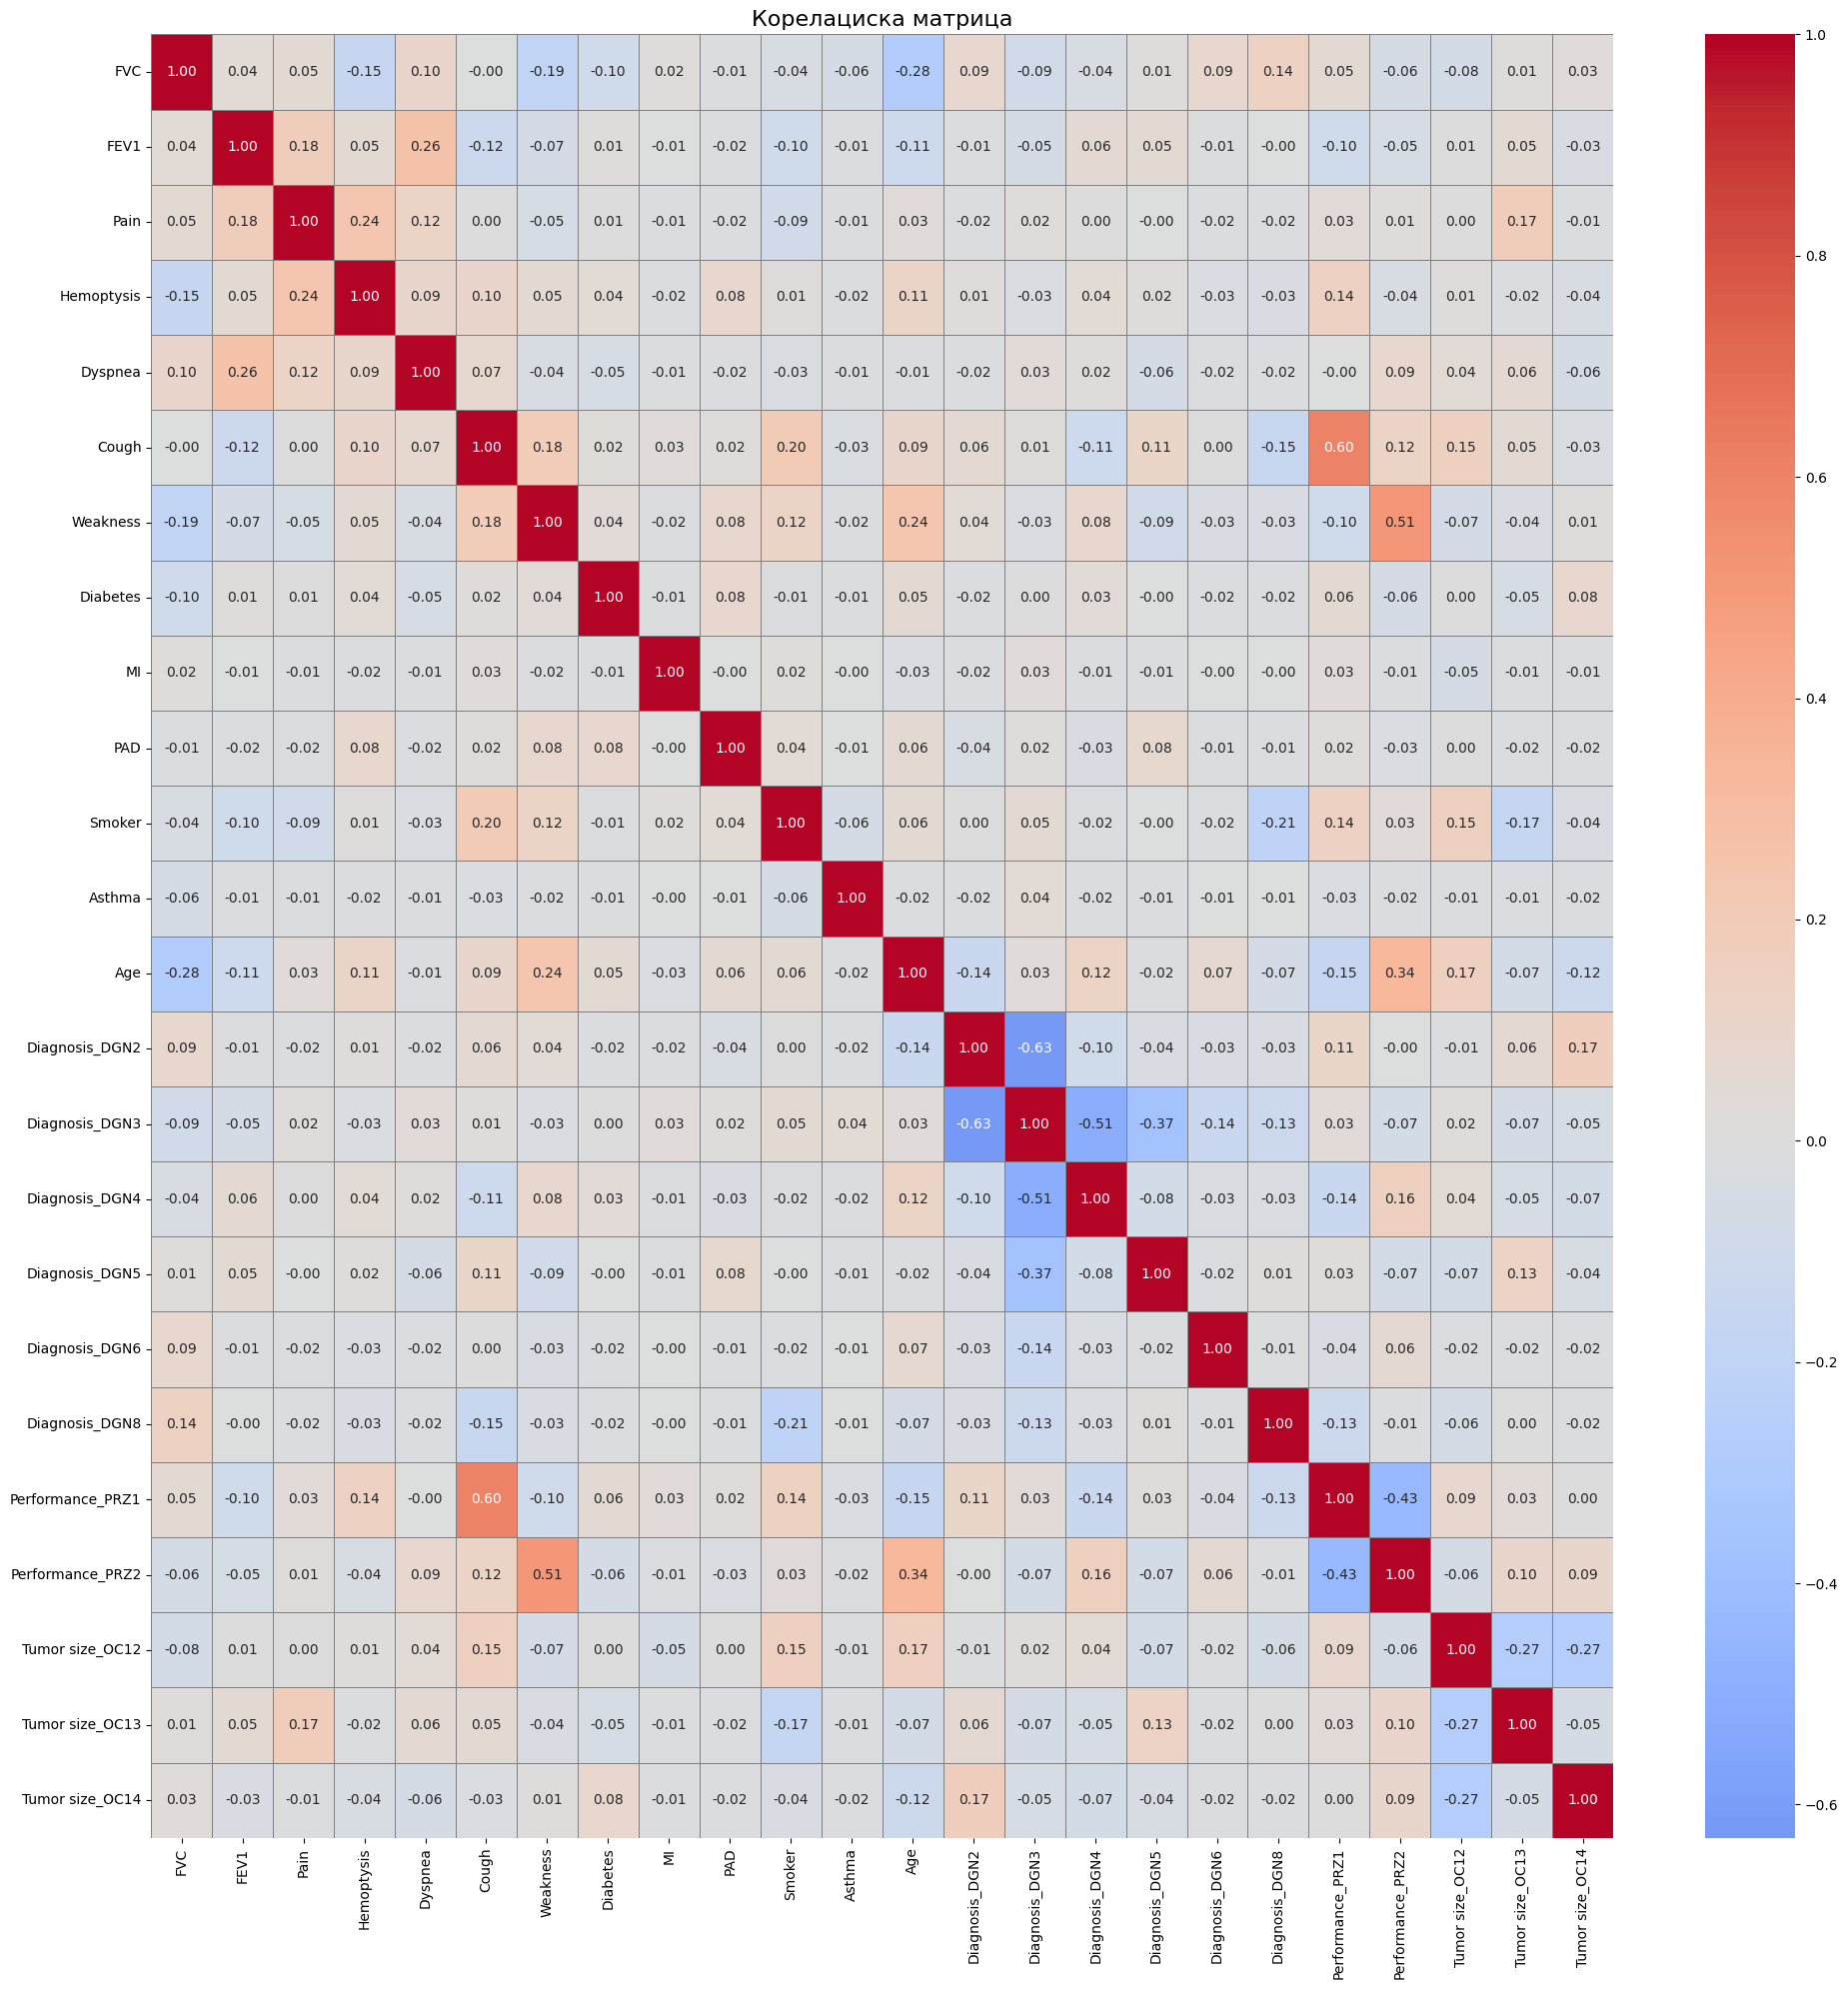

Корелација со class променливата:
Diagnosis_DGN5      0.189
Tumor size_OC12     0.152
Cough               0.144
Performance_PRZ2    0.131
Pain                0.129
Performance_PRZ1    0.121
FEV1                0.114
Tumor size_OC14     0.108
Smoker              0.107
Diagnosis_DGN3      0.105
Diagnosis_DGN6      0.085
Diagnosis_DGN2      0.078
Diabetes            0.074
Tumor size_OC13     0.064
Asthma              0.060
PAD                 0.057
Age                 0.043
MI                  0.042
Diagnosis_DGN8      0.042
Diagnosis_DGN4      0.036
FVC                 0.033
Hemoptysis          0.011
Dyspnea             0.008
Weakness            0.005
dtype: float64


In [85]:
plt.figure(figsize=(20, 20))
correlation_matrix = X_train_resampled.corr()

sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap='coolwarm', center=0,linewidths=0.5, linecolor='gray', cbar=True)
plt.title('Корелациска матрица', fontsize=16)
plt.tight_layout()
plt.show()

correlation_with_target = X_train_resampled.corrwith(y_train_resampled).abs()
correlation_with_target = correlation_with_target.sort_values(ascending=False)

print("Корелација со class променливата:")
print(correlation_with_target.round(3))

Според матрицата на корелација може да забележиме дека најголем дел од карактеристиките немаат силна корелација една со друга.

Може да ги издвоиме Cough и Performance_PRZ1 кои имаат меѓусебна корелација од 0.60, Performance_PRZ2 со Weakness имаат меѓусебна корелација од 0.51, Diagnosis_DGN3 со Diagnosis_DGN2 имаат негативна меѓусебна корелација од -0.63, како и Diagnosis_DGN3 со Diagnosis_DGN4 кои имаат негативна корелација од -0.51.

Топ 5 карактеристики кои имаат најсилна корелација со излезната променлива Class се:

- Diagnosis_DGN5: 0.189
- Tumor size_OC12: 0.152
- Cough: 0.144
- Performance_PRZ2: 0.131
- Pain: 0.129

Од ова може да заклучиме дека дијагнозата DGN5, големината на тумор OC12, кашлицата, статусот на перформанси со вредност PRZ2 како и болката се карактеристиките со најголемо влијание врз излезната променлива.
Сепак, важно е да се напомене дека сите овие корелации се релативно слаби (под 0.2), што сугерира дека комбинација од повеќе карактеристики е неопходна за прецизно предвидување на исходот од операцијата.

Feature importance според Random Forest:
FEV1                0.163
FVC                 0.162
Age                 0.155
Tumor size_OC12     0.110
Performance_PRZ1    0.068
Diagnosis_DGN3      0.042
Diagnosis_DGN5      0.036
Diagnosis_DGN4      0.031
Tumor size_OC14     0.028
Diagnosis_DGN2      0.027
Cough               0.024
Smoker              0.023
Hemoptysis          0.022
Weakness            0.020
Performance_PRZ2    0.020
Tumor size_OC13     0.018
Diabetes            0.015
Pain                0.013
Dyspnea             0.011
Diagnosis_DGN8      0.005
PAD                 0.003
Diagnosis_DGN6      0.002
Asthma              0.001
MI                  0.000
dtype: float64


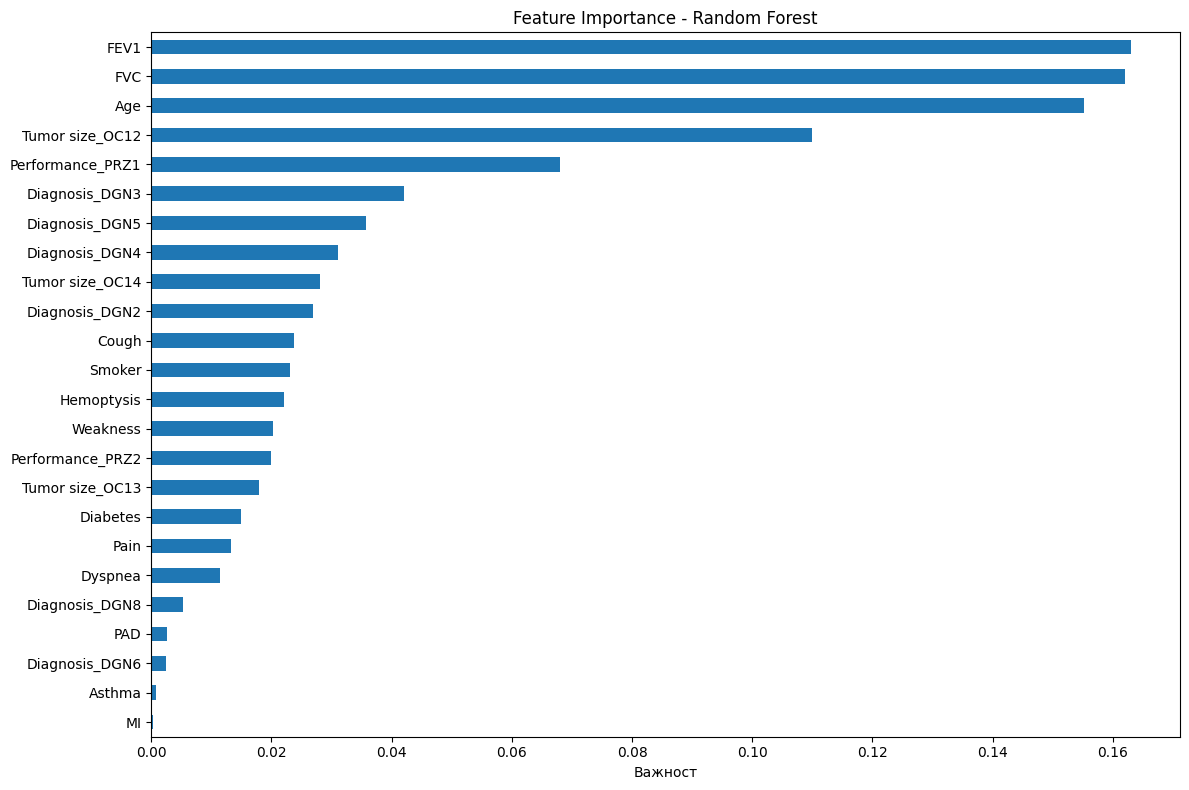

In [86]:
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train_resampled, y_train_resampled)

importances = rf.feature_importances_
feature_importance = pd.Series(importances, index=X_train_resampled.columns)
feature_importance = feature_importance.sort_values(ascending=False)

print("Feature importance според Random Forest:")
print(feature_importance.round(3))

plt.figure(figsize=(12, 8))
feature_importance.plot(kind='barh')
plt.title('Feature Importance - Random Forest')
plt.xlabel('Важност')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()


Според анализата на важноста на карактеристиките со Random Forest моделот, најважни карактеристики за исходот од операцијата се:

Топ 5 најважни карактеристики:
*   FEV1: 0.163
*   FVC: 0.162
*   Age: 0.155
*   Tumor size_OC12: 0.110
*   Performance_PRZ1: 0.068

Интересно е да се забележи значителната разлика меѓу корелациската анализа и Random Forest feature importance.
Додека корелациската анализа покажа дека FEV1 (0.114) и FVC (0.033) имаат слаби линеарни врски со исходот, Random Forest моделот ги идентификува овие карактеристики како најважни.

Оваа разлика укажува на присуство на нелинеарни релации и комплексни интеракции меѓу белодробната функција и други клинички карактеристики, кои линеарната корелација не може да ги детектира.

Дијагнозите (DGN3: 0.042, DGN5: 0.036) и клиничките симптоми како кашлица (0.024) и болка (0.013) покажуваат умерена до ниска важност во Random Forest моделот, што е во согласност со нивните слаби корелации.

In [87]:
def plot_confusion_matrix(y_true, y_pred, model_name):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(6, 4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
                xticklabels=np.unique(y_true), yticklabels=np.unique(y_true))
    plt.xlabel("Предвидена класа")
    plt.ylabel("Вистинска класа")
    plt.title(f"{model_name} - Матрица на конфузија")
    plt.tight_layout()
    plt.show()

Threshold: 0.3
Accuracy:  0.3121
Precision: 0.1415
Recall:    0.7143
F1-Score:  0.2362
AUC:       0.5317


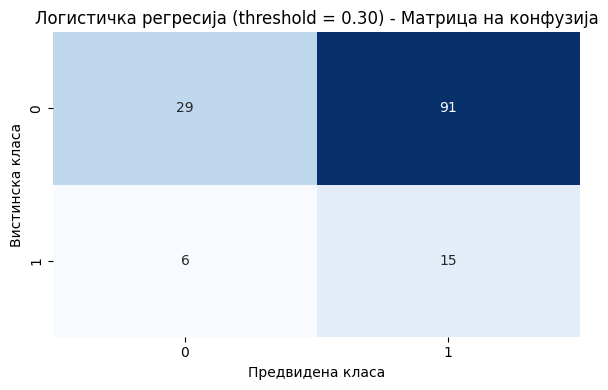

In [88]:
threshold = 0.30

model_results = {}

lr = LogisticRegression(
    class_weight='balanced',
    random_state=42,
    max_iter=1000,
    solver='saga',
    C=10,
    penalty='l2'
)

lr.fit(X_train_resampled, y_train_resampled)
y_pred_proba_lr = lr.predict_proba(X_test)[:, 1]

y_pred_lr = (y_pred_proba_lr >= threshold).astype(int)

accuracy_lr = accuracy_score(y_test, y_pred_lr)
precision_lr = precision_score(y_test, y_pred_lr)
recall_lr = recall_score(y_test, y_pred_lr)
f1_lr = f1_score(y_test, y_pred_lr)
auc_lr = roc_auc_score(y_test, y_pred_proba_lr)

model_results['Logistic Regression (thr=0.30)'] = {
    'Accuracy': accuracy_lr,
    'Precision': precision_lr,
    'Recall': recall_lr,
    'F1-Score': f1_lr,
    'AUC': auc_lr
}

print(f"Threshold: {threshold}")
print(f"Accuracy:  {accuracy_lr:.4f}")
print(f"Precision: {precision_lr:.4f}")
print(f"Recall:    {recall_lr:.4f}")
print(f"F1-Score:  {f1_lr:.4f}")
print(f"AUC:       {auc_lr:.4f}")

lr_report_df = plot_confusion_matrix(
    y_test,
    y_pred_lr,
    "Логистичка регресија (threshold = 0.30)"
)


Threshold: 0.3
Accuracy:  0.7092
Precision: 0.2727
Recall:    0.5714
F1-Score:  0.3692
AUC:       0.6806


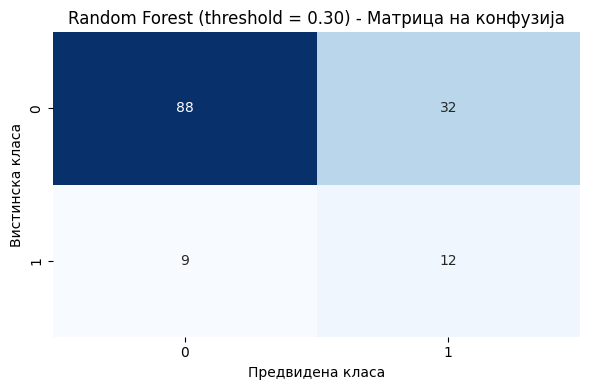

In [89]:
rf = RandomForestClassifier(
    class_weight='balanced',
    max_depth=25,
    n_estimators=300,
    random_state=42
)

rf.fit(X_train_resampled, y_train_resampled)

y_pred_proba_rf = rf.predict_proba(X_test)[:, 1]
y_pred_rf = (y_pred_proba_rf >= threshold).astype(int)

accuracy_rf = accuracy_score(y_test, y_pred_rf)
precision_rf = precision_score(y_test, y_pred_rf)
recall_rf = recall_score(y_test, y_pred_rf)
f1_rf = f1_score(y_test, y_pred_rf)
auc_rf = roc_auc_score(y_test, y_pred_proba_rf)

model_results['Random Forest (thr=0.30)'] = {
    'Accuracy': accuracy_rf,
    'Precision': precision_rf,
    'Recall': recall_rf,
    'F1-Score': f1_rf,
    'AUC': auc_rf
}

print(f"Threshold: {threshold}")
print(f"Accuracy:  {accuracy_rf:.4f}")
print(f"Precision: {precision_rf:.4f}")
print(f"Recall:    {recall_rf:.4f}")
print(f"F1-Score:  {f1_rf:.4f}")
print(f"AUC:       {auc_rf:.4f}")

plot_confusion_matrix(
    y_test,
    y_pred_rf,
    "Random Forest (threshold = 0.30)")


Threshold: 0.3
Accuracy:  0.7872
Precision: 0.3448
Recall:    0.4762
F1-Score:  0.4000
AUC:       0.6552


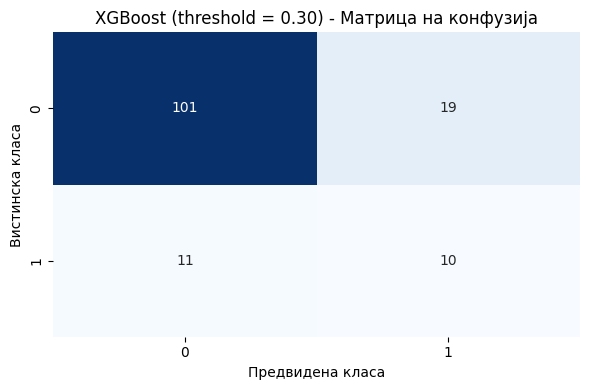

In [90]:
xgb = XGBClassifier(
    eval_metric='logloss',
    learning_rate=0.1,
    max_depth=7,
    n_estimators=300,
    random_state=42)

xgb.fit(X_train_resampled, y_train_resampled)

y_pred_proba_xgb = xgb.predict_proba(X_test)[:, 1]

y_pred_xgb = (y_pred_proba_xgb >= threshold).astype(int)

accuracy_xgb = accuracy_score(y_test, y_pred_xgb)
precision_xgb = precision_score(y_test, y_pred_xgb)
recall_xgb = recall_score(y_test, y_pred_xgb)
f1_xgb = f1_score(y_test, y_pred_xgb)
auc_xgb = roc_auc_score(y_test, y_pred_proba_xgb)

model_results['XGBoost (thr=0.30)'] = {
    'Accuracy': accuracy_xgb,
    'Precision': precision_xgb,
    'Recall': recall_xgb,
    'F1-Score': f1_xgb,
    'AUC': auc_xgb
}

print(f"Threshold: {threshold}")
print(f"Accuracy:  {accuracy_xgb:.4f}")
print(f"Precision: {precision_xgb:.4f}")
print(f"Recall:    {recall_xgb:.4f}")
print(f"F1-Score:  {f1_xgb:.4f}")
print(f"AUC:       {auc_xgb:.4f}")

plot_confusion_matrix(
    y_test,
    y_pred_xgb,
    "XGBoost (threshold = 0.30)"
)


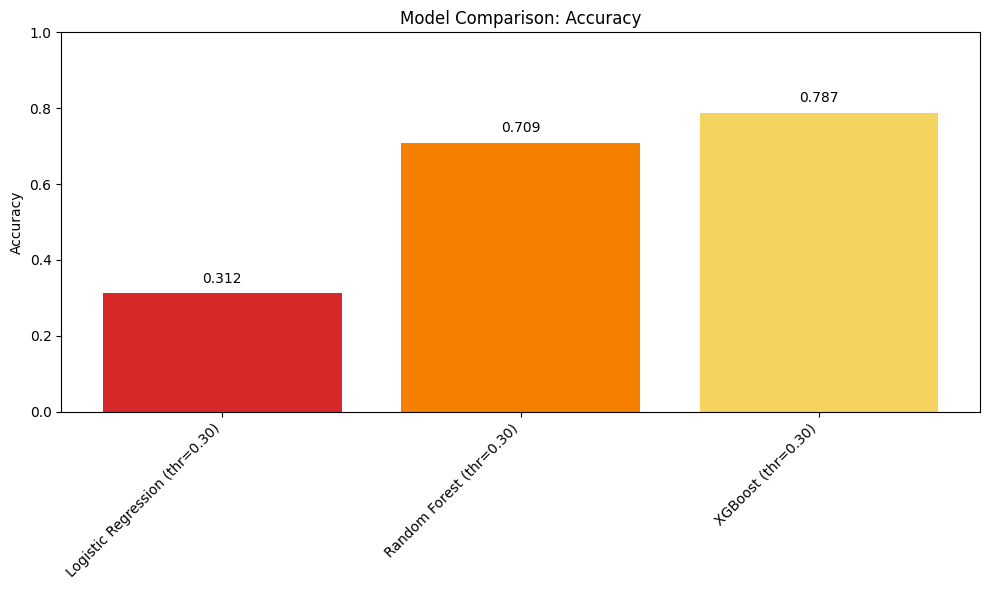

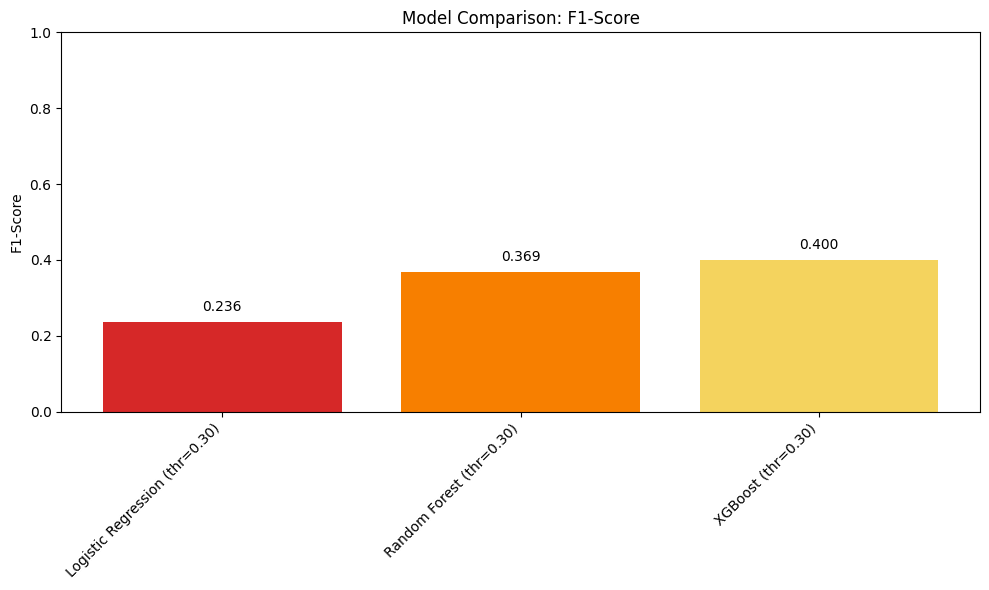

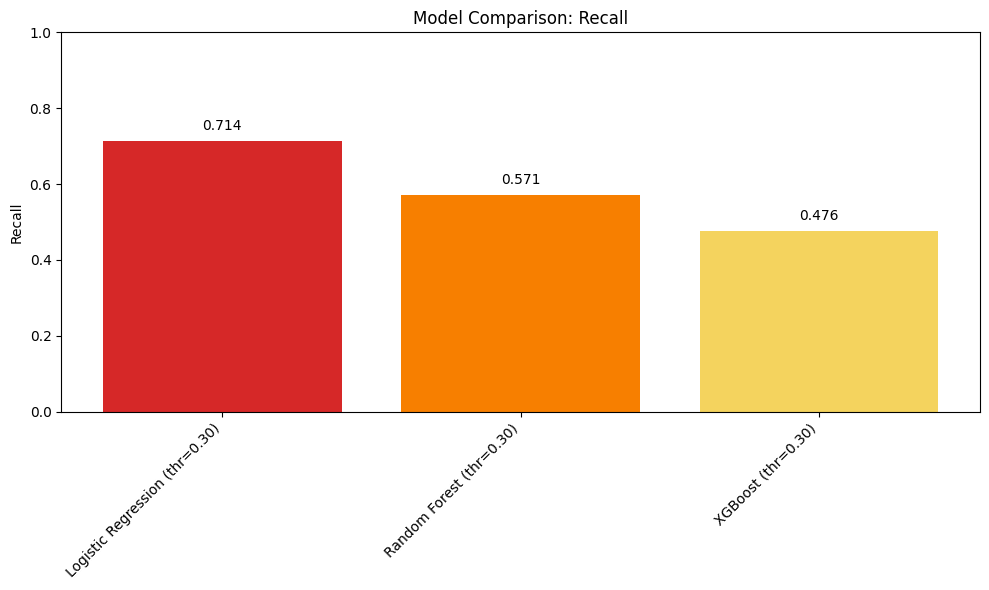

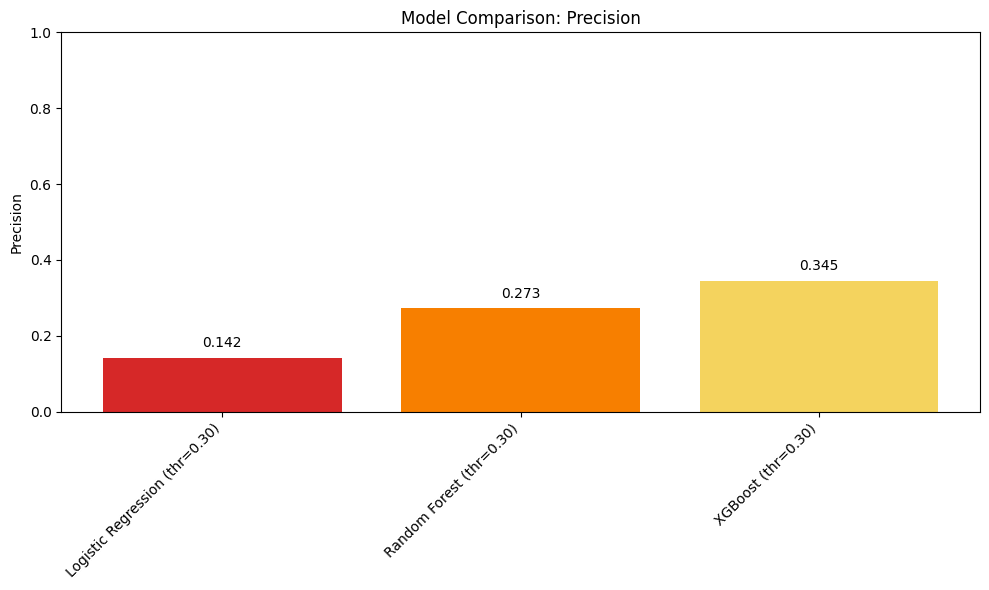

In [91]:
def plot_metrics_bars_colored(model_results):
    metrics = ['Accuracy', 'F1-Score', 'Recall', 'Precision']
    models = list(model_results.keys())

    colors = ['#D62828','#F77F00','#F4D35E']

    for metric in metrics:
        values = [model_results[model][metric] for model in models]

        plt.figure(figsize=(10,6))
        bars = plt.bar(models, values, color=colors[:len(models)])
        plt.ylim(0,1)
        plt.title(f'Model Comparison: {metric}')
        plt.ylabel(metric)
        plt.xticks(rotation=45, ha='right')

        for bar, value in zip(bars, values):
            plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.02,
                     f'{value:.3f}', ha='center', va='bottom', fontsize=10)

        plt.tight_layout()
        plt.show()

plot_metrics_bars_colored(model_results)


## Споредба на моделите и заклучок

Во овој проект споредував три модели Logistic Regression, Random Forest и XGBoost  за предвидување на смртност на пациенти кои направиле операција на белите дробови.

На почеток, кога го користев стандардниот threshold од 0.5, XGBoost имаше највисока точност, но многу од ризичните пациенти (класа 1) не беа детектирани.

Тоа покажува дека accuracy не е доволна метрика кај неурамнотежени податоци особено во медицински случаи каде најважно е да се најдат ризичните пациенти.

Поради тоа, го намалив threshold на 0.3 за сите модели.
Ова го зголеми recall кај сите модели особено кај Random Forest и XGBoost што значи дека повеќе од ризичните пациенти сега се детектираат.
Precision падна малку, а F1-score остана приближно ист или се подобри.

Logistic Regression имаше највисок recall, но AUC e многу низок, што покажува дека моделот не ги разликува добро класите.

Како заклучок, Random Forest и XGBoost се подобри при детекција на пациенти со висок ризик, а резултатите покажуваат дека при работа со неурамнотежени податоци многу е важно да се размислува за избор на threshold и за тоа кои метрики се најважни.

Причините за ограничените резултати на моделите се: мал број примери од позитивната класа (само 70 пациенти), слаба корелација помеѓу карактеристиките и исходот, и комплексни нелинеарни интеракции кои моделите тешко ги учат.

И покрај користење на техники за баланс како SMOTE, овие фактори ја ограничуваат способноста за точно предвидување на ризичните пациенти.

